# Image cropping function in action
## load data

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from spatial_tools.image.crop import crop_generator
from spatial_tools.image.object import ImageContainer

# path to "raw" dataset folder
BASE_PATH = "../../data"
dataset_name = "V1_Adult_Mouse_Brain"
dataset_folder = os.path.join(
    BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla"
)
image_file = os.path.join(dataset_folder, f"{dataset_name}_image.tif")

In [2]:
adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)
img = ImageContainer(image_file)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/hannah.spitzer/opt/miniconda3/envs/spatial-scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/hannah.spitzer/opt/miniconda3/envs/spatial-scanpy/lib/python3.7/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


img is an ImageContainer object, containing a .data attr which is an xarray

In [3]:
img.data

<xarray.Dataset>
Dimensions:   (channels: 3, x: 11291, y: 11757)
Coordinates:
  * channels  (channels) int64 1 2 3
Dimensions without coordinates: x, y
Data variables:
    image     (channels, y, x) uint8 ...

## crop image using crop_generator
iterates over all obs_ids, returning (obs_id, crop).
Per default, the crop has the size of the spot_diameter

In [4]:
crop_iter = crop_generator(adata, img)
obs_id, crop = next(crop_iter)
print(obs_id, crop.shape)

AAACAAGTATCTCCCA-1 (89, 89, 3)


location of the obs that we have just cropped

8230 7237


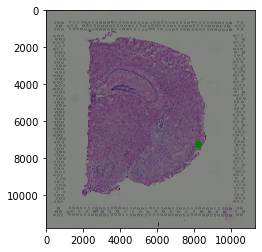

In [5]:
x , y = adata[obs_id].obsm['spatial'][0]
print(x, y)
plt.scatter(x, y, c='green')
plt.imshow(img.data['image'].transpose('y', 'x', 'channels').data)

### try different neighborhood sizes
Note that the function also works when the range is outside the image

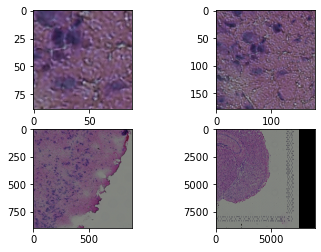

In [6]:
fig, axes = plt.subplots(2,2)
for ax, sizef in zip(axes.flat, [1,2,10,100]):
    obs_id, crop = next(crop_generator(adata, img, sizef=sizef))
    ax.imshow(crop)

### try different scales
Note how the crops get smaller with smaller `scale`

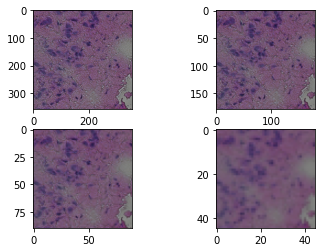

In [9]:
fig, axes = plt.subplots(2,2)
for ax, scale in zip(axes.flat, [1,0.5,0.25,0.125]):
    obs_id, crop = next(crop_generator(adata, img, sizef=4, scale=scale))
    ax.imshow(crop)

## mask crops with circle
different neighborhood sizes and scales

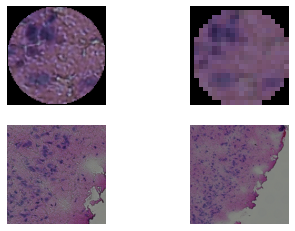

In [10]:
_, crop_1 = next(crop_generator(adata, img, sizef=1, scale=1, mask_circle=True))
_, crop_2 = next(crop_generator(adata, img, sizef=1, scale=0.25, mask_circle=True))
_, crop_3 = next(crop_generator(adata, img, sizef=5, scale=1))
_, crop_4 = next(crop_generator(adata, img, sizef=10, scale=1))

fig, axes = plt.subplots(2,2)
axes[0][0].imshow(crop_1)
axes[0][1].imshow(crop_2)
axes[1][0].imshow(crop_3)
axes[1][1].imshow(crop_4)
for ax in axes.flat:
    ax.axis('off')
#plt.savefig('crop_example.png')

## Fluorescence dataset

In [11]:
dataset_name = "V1_Adult_Mouse_Brain_Coronal_Section_2"
dataset_folder = os.path.join(
    BASE_PATH, "2020_10XFluoVisium_MouseBrain2_giovanni.palla"
)
image_file = os.path.join(dataset_folder, f"{dataset_name}_image.tif")

In [12]:
adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)
img = ImageContainer(image_file)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


this img consists of 3 different DataArrays (the different stains). By default, cropping always concatenates all available data, but also individual images can be selected.

When cropping, we need to manually define the dtype to be uint8 to allow plotting with matplotlib

In [13]:
img.data

<xarray.Dataset>
Dimensions:   (channels: 1, x: 24240, y: 24240)
Coordinates:
  * channels  (channels) int64 1
Dimensions without coordinates: x, y
Data variables:
    image_0   (channels, y, x) uint16 ...
    image_1   (channels, y, x) uint16 ...
    image_2   (channels, y, x) uint16 ...

(178, 178, 3) uint8


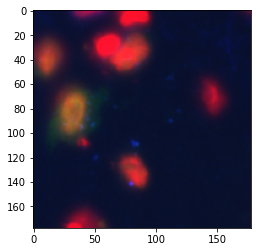

In [14]:
obs_id, crop = next(crop_generator(adata, img, dtype='uint8'))
print(crop.shape, crop.dtype)
plt.imshow(crop)

(178, 178, 1) uint8


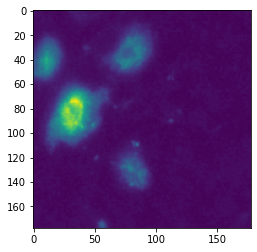

In [15]:
obs_id, crop = next(crop_generator(adata, img, img_id='image_1', dtype='uint8'))
print(crop.shape, crop.dtype)
plt.imshow(crop)